<a href="https://colab.research.google.com/github/MarceloCapeletti/creditcard_fraud_detection/blob/main/projeto_credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de descrição e detecção de fraudes em banco de dados de transações em cartão de crédito

O banco é disponibilizado pela plataforma Kaggle:
https://www.kaggle.com/mlg-ulb/creditcardfraud

Para contexto, o banco apresenta transações de cartão de credito de dois dias de semtebro de 2013 na Europa, em que ocorreram 284807 transações com 492 fraudes, sendo assim considerado um banco de dados desbalanceado.

O objetivo deste notebook é realizar uma análise descritiva das entradas disponibilizadas no banco, após aplicação e otimização dos hiperparâmetros de métodos de detecção Random Forest, KNN e Rede Neural Artificial. Dado a caracteristica do banco desbalanceado, os métodos serão empregados como detectores de outliers com uma aprendizagem supervisionada.

In [1]:
#----------------------------------------------------------------------------------------------------------------
# INSTALAR BIBLIOTECAS
#----------------------------------------------------------------------------------------------------------------

#!pip install pandas==1.3.4
#!pip install numpy==1.21.0
#!pip install matplotlib==3.4.3
#pip install keras_tuner

In [2]:
#----------------------------------------------------------------------------------------------------------------
# IMPORTAR BIBLIOTECAS
#----------------------------------------------------------------------------------------------------------------

# BIBLIOTECAS DE MANIPULAÇÃO DE DADOS

import pandas as pd
import numpy as np


# BIBLIOTECAS PARA PLOTAR DADOS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# BIBLIOTECAS ALGORITMOS DE  APRENDIZADO DE MÁQUINA E TUNING

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import keras_tuner as kt
#from keras_tuner import Objective
#from keras_tuner.tuners import BayesianOptimization 
#from keras.callbacks import TensorBoard, EarlyStopping


# BIBLIOTECA TIME

import time

### CONFIGURANDO PANDAS

In [3]:
#----------------------------------------------------------------------------------------------------------------
# CONFIGURANDO E ESTILIZANDO PANDAS
#----------------------------------------------------------------------------------------------------------------

pd.set_option('display.max_rows',600) 
pd.get_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('precision',4)
#pd.reset_option('all')



def positiveandnegative_colors(value):

  if value > 0: 
    color = 'black'
  else: 
    color = 'red'

  return 'color: %s' % color

stylepattern = [
  {'selector': 'th',
    'props': [('background', 'white'), 
              ('color', 'black'),
              ('font-family', 'arial'),
              ('text-align', 'center')]},

  {'selector': 'tr:nth-of-type(odd)',
    'props': [('background', '#DCDCDC')]}, 
 
  {'selector': 'tr:nth-of-type(even)',
    'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
    'props': [('background-color', '#0000FF')]}
          ]


ESTILIZANDO E CONFIGURANDO PLOTTAGEM E IMPRESSÕES DOS DADOS 


## Carregar dataframe de transações de crédito

In [4]:
df_credit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df_credit.columns.name = 'Features'
df_credit.index.name = 'Index'
df_credit.head(20).style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0
5,2.0000,-0.4260,0.9605,1.1411,-0.1683,0.4210,-0.0297,0.4762,0.2603,-0.5687,-0.3714,1.3413,0.3599,-0.3581,-0.1371,0.5176,0.4017,-0.0581,0.0687,-0.0332,0.0850,-0.2083,-0.5598,-0.0264,-0.3714,-0.2328,0.1059,0.2538,0.0811,3.6700,0
6,4.0000,1.2297,0.1410,0.0454,1.2026,0.1919,0.2727,-0.0052,0.0812,0.4650,-0.0993,-1.4169,-0.1538,-0.7511,0.1674,0.0501,-0.4436,0.0028,-0.6120,-0.0456,-0.2196,-0.1677,-0.2707,-0.1541,-0.7801,0.7501,-0.2572,0.0345,0.0052,4.9900,0
7,7.0000,-0.6443,1.4180,1.0744,-0.4922,0.9489,0.4281,1.1206,-3.8079,0.6154,1.2494,-0.6195,0.2915,1.7580,-1.3239,0.6861,-0.0761,-1.2221,-0.3582,0.3245,-0.1567,1.9435,-1.0155,0.0575,-0.6497,-0.4153,-0.0516,-1.2069,-1.0853,40.8000,0
8,7.0000,-0.8943,0.2862,-0.1132,-0.2715,2.6696,3.7218,0.3701,0.8511,-0.3920,-0.4104,-0.7051,-0.1105,-0.2863,0.0744,-0.3288,-0.2101,-0.4998,0.1188,0.5703,0.0527,-0.0734,-0.2681,-0.2042,1.0116,0.3732,-0.3842,0.0117,0.1424,93.2000,0


Infelizmente devido a confiabilidade as features de entradas foram alteradas com PCA, que é definido como uma transformação linear ortogonal que transforma os dados em um novo sistema de coordenadas.

As features com valores reais são 'Time' que representa o valor em segundos entre transações, e 'Amount' representando o valor monetário de cada transação.

Os gráficos a seguir demonstra o Tempo x Valor das transações , demarcado operações fraudulentas

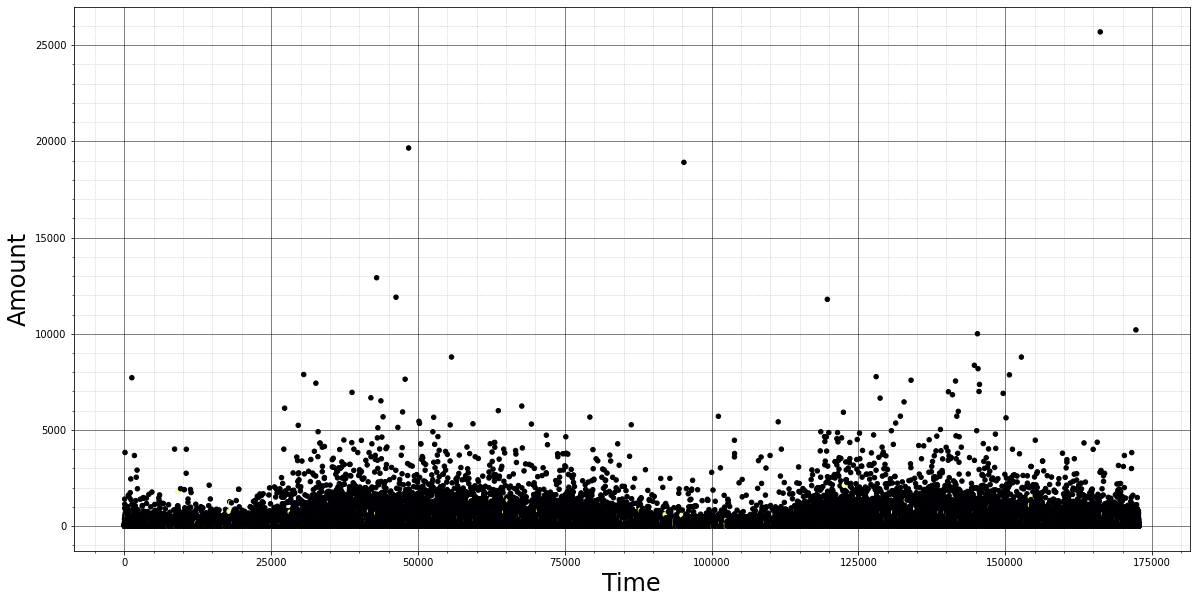

In [5]:
ax = df_credit[['Time','Amount']].plot(kind='scatter',x='Time', y = 'Amount',figsize=(20,10), c=df_credit['Class'],colormap='inferno',colorbar=False)

ax.set_xlabel('Time',fontdict={'fontsize':24})
ax.set_ylabel('Amount',fontdict={'fontsize':24})
ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 


Zoom in, com objetivo de melhorar visualização

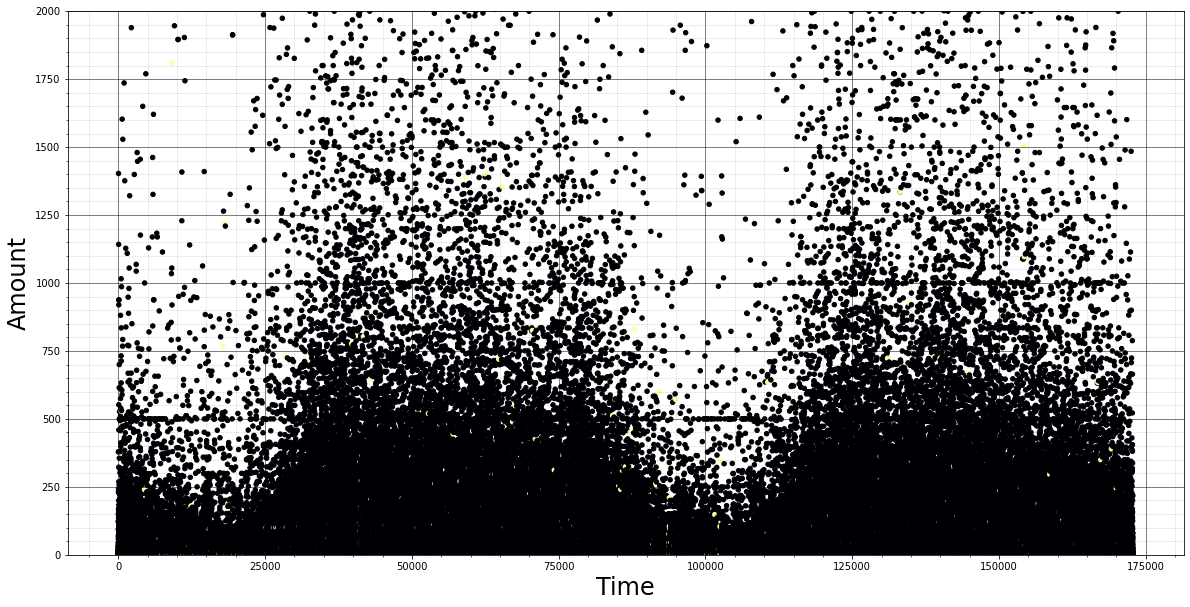

In [6]:
ax = df_credit[['Time','Amount']].plot(kind='scatter', x='Time', y='Amount', figsize=(20,10), ylim=(0,2000),c=df_credit['Class'],colormap='inferno',colorbar=False)

ax.set_xlabel('Time',fontdict={'fontsize':24})
ax.set_ylabel('Amount',fontdict={'fontsize':24})
ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 

### Histogramas / Distribuição de frequências V1, V2 ... V28
Para todas as variáveis alteradas, é realizado impressão de histogramas com objetivo de visualizar como elas estão distribuidas, filtrando como consumidores normais e fraudulentos


---



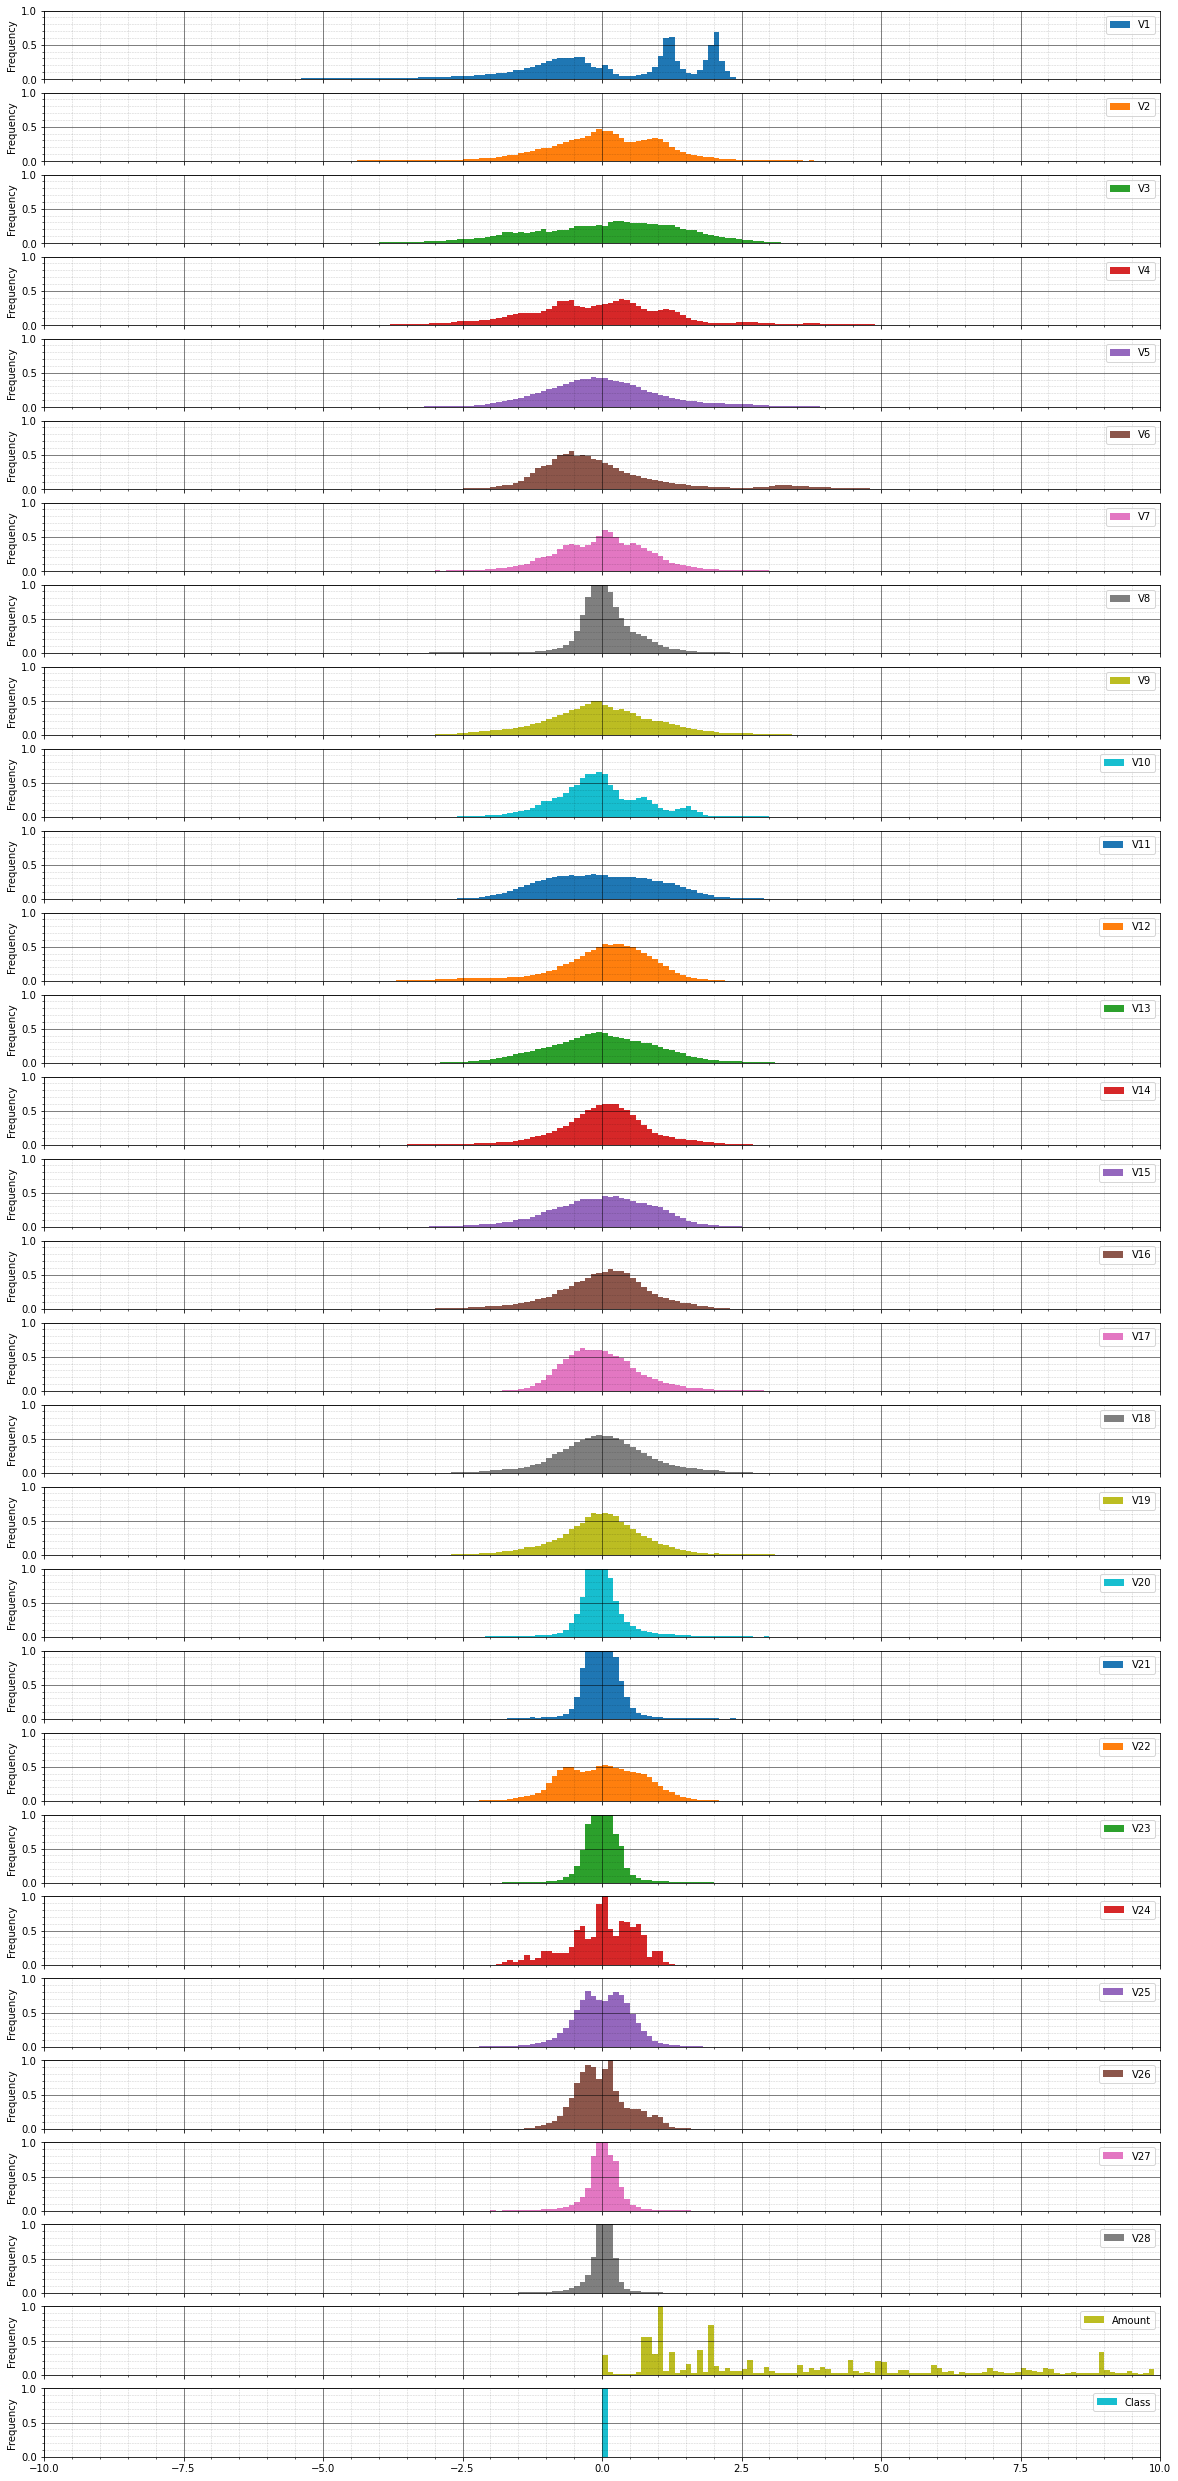

In [7]:
ax = df_credit.iloc[:,1:31].query('Class == 0').plot(kind='hist', figsize=(20,45),xlim=(-10,10),ylim=(0,1),bins=np.arange(-10, 10, .1),subplots=True,density=True)

for subplot in ax:

  subplot.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
  subplot.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
  subplot.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
  subplot.xaxis.set_minor_locator(AutoMinorLocator())
  subplot.yaxis.set_minor_locator(AutoMinorLocator())
  subplot.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
  subplot.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 

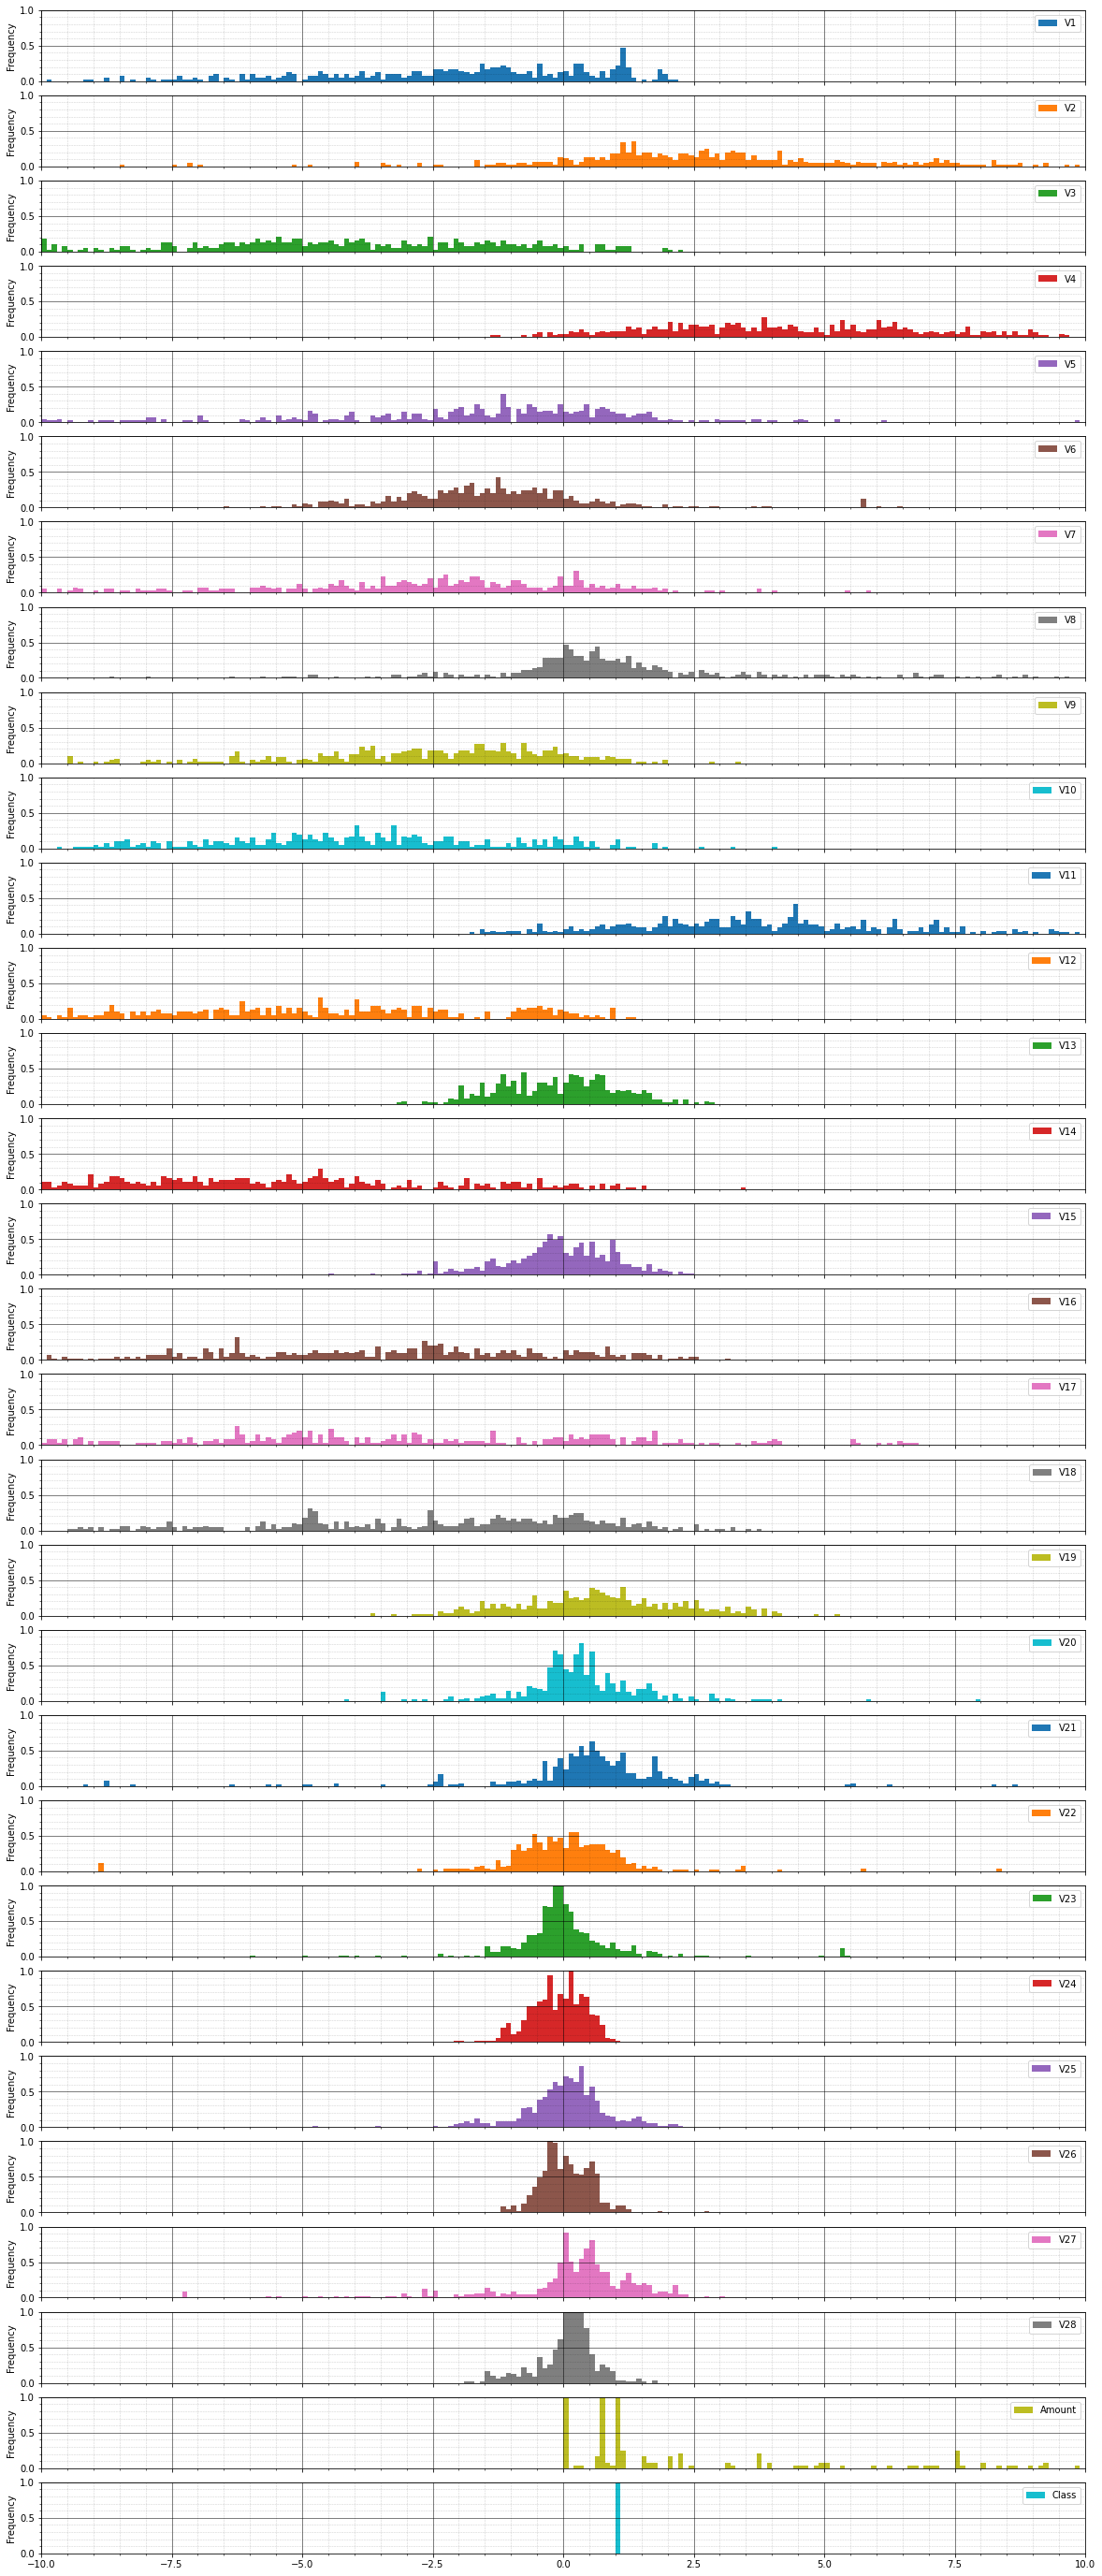

In [8]:
ax = df_credit.iloc[:,1:31].query('Class == 1').plot(kind='hist', figsize=(20,50),xlim=(-10,10),ylim=(0,1),bins=np.arange(-10, 10, .1),subplots=True,density=True)

for subplot in ax:

  subplot.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
  subplot.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
  subplot.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
  subplot.xaxis.set_minor_locator(AutoMinorLocator())
  subplot.yaxis.set_minor_locator(AutoMinorLocator())
  subplot.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
  subplot.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 

### BoxPlot das váriaveis V1 ~ V28

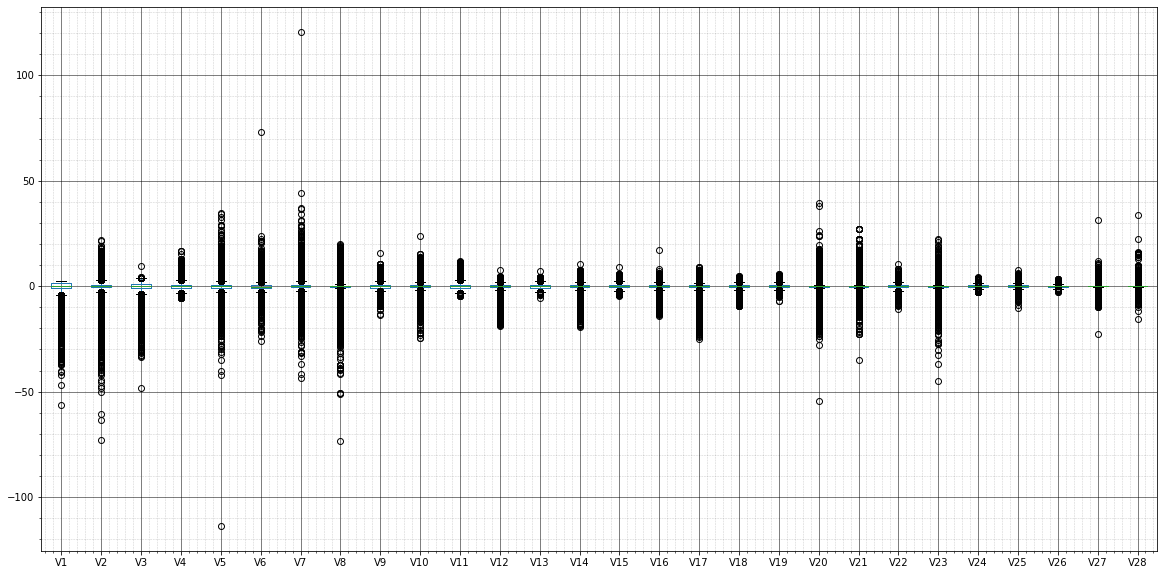

In [9]:
ax = df_credit.iloc[:,1:29].plot(kind='box', figsize=(20,10))

ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

### Filtrando as operações fraudulentas e regulares


In [10]:
df_credit.loc[(df_credit["Class"] == 0)].describe()\
              .style.set_table_styles(stylepattern).applymap(positiveandnegative_colors) # Descrição do Dataframe filtrando operações fraudulentas

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000
mean,94838.2023,0.0083,-0.0063,0.0122,-0.0079,0.0055,0.0024,0.0096,-0.0010,0.0045,0.0098,-0.0066,0.0108,0.0002,0.0121,0.0002,0.0072,0.0115,0.0039,-0.0012,-0.0006,-0.0012,-0.0000,0.0001,0.0002,-0.0001,-0.0001,-0.0003,-0.0001,88.2910,0.0000
std,47484.0158,1.9298,1.6361,1.4594,1.3993,1.3570,1.3299,1.1788,1.1613,1.0894,1.0442,1.0031,0.9459,0.9951,0.8970,0.9151,0.8448,0.7495,0.8249,0.8117,0.7694,0.7167,0.7237,0.6215,0.6058,0.5207,0.4822,0.3998,0.3296,250.1051,0.0000
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-31.7649,-73.2167,-6.2907,-14.7411,-4.7975,-15.1450,-5.7919,-18.3921,-4.3913,-10.1156,-17.0984,-5.3667,-7.2135,-54.4977,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54230.0000,-0.9175,-0.5995,-0.8845,-0.8501,-0.6894,-0.7668,-0.5514,-0.2086,-0.6404,-0.5329,-0.7634,-0.4021,-0.6481,-0.4225,-0.5828,-0.4655,-0.4826,-0.4974,-0.4564,-0.2118,-0.2285,-0.5424,-0.1617,-0.3544,-0.3171,-0.3271,-0.0709,-0.0529,5.6500,0.0000
50%,84711.0000,0.0200,0.0641,0.1822,-0.0224,-0.0535,-0.2731,0.0411,0.0220,-0.0500,-0.0919,-0.0349,0.1417,-0.0135,0.0519,0.0483,0.0674,-0.0648,-0.0028,0.0031,-0.0626,-0.0298,0.0067,-0.0111,0.0411,0.0164,-0.0522,0.0012,0.0112,22.0000,0.0000
75%,139333.0000,1.3162,0.8004,1.0284,0.7376,0.6122,0.3996,0.5710,0.3262,0.5982,0.4551,0.7364,0.6192,0.6625,0.4941,0.6488,0.5237,0.3999,0.5011,0.4575,0.1324,0.1856,0.5284,0.1475,0.4399,0.3506,0.2407,0.0906,0.0780,77.0500,0.0000
max,172792.0000,2.4549,18.9025,9.3826,16.8753,34.8017,73.3016,120.5895,18.7093,15.5950,23.7451,10.0022,7.8484,7.1269,10.5268,8.8777,17.3151,9.2535,5.0411,5.5920,39.4209,22.6149,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,0.0000


In [11]:
df_credit.loc[(df_credit.Class == 1)].describe()\
                .style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000
mean,80746.8069,-4.7719,3.6238,-7.0333,4.5420,-3.1512,-1.3977,-5.5687,0.5706,-2.5811,-5.6769,3.8002,-6.2594,-0.1093,-6.9717,-0.0929,-4.1399,-6.6658,-2.2463,0.6807,0.3723,0.7136,0.0140,-0.0403,-0.1051,0.0414,0.0516,0.1706,0.0757,122.2113,1.0000
std,47835.3651,6.7837,4.2912,7.1109,2.8733,5.3725,1.8581,7.2068,6.7978,2.5009,4.8973,2.6786,4.6545,1.1045,4.2789,1.0499,3.8650,6.9706,2.8994,1.5399,1.3466,3.8693,1.4946,1.5796,0.5156,0.7972,0.4717,1.3768,0.5473,256.6833,0.0000
min,406.0000,-30.5524,-8.4022,-31.1037,-1.3133,-22.1055,-6.4063,-43.5572,-41.0443,-13.4341,-24.5883,-1.7022,-18.6837,-3.1278,-19.2143,-4.4989,-14.1299,-25.1628,-9.4987,-3.6819,-4.1282,-22.7976,-8.8870,-19.2543,-2.0280,-4.7816,-1.1527,-7.2635,-1.8693,0.0000,1.0000
25%,41241.5000,-6.0361,1.1882,-8.6435,2.3730,-4.7928,-2.5015,-7.9653,-0.1953,-3.8724,-7.7567,1.9734,-8.6882,-0.9791,-9.6927,-0.6435,-6.5629,-11.9451,-4.6646,-0.2994,-0.1718,0.0418,-0.5338,-0.3422,-0.4368,-0.3143,-0.2594,-0.0200,-0.1089,1.0000,1.0000
50%,75568.5000,-2.3425,2.7179,-5.0753,4.1771,-1.5230,-1.4246,-3.0344,0.6215,-2.2088,-4.5788,3.5862,-5.5025,-0.0656,-6.7297,-0.0572,-3.5498,-5.3029,-1.6643,0.6468,0.2847,0.5921,0.0484,-0.0731,-0.0608,0.0884,0.0043,0.3949,0.1463,9.2500,1.0000
75%,128483.0000,-0.4192,4.9713,-2.2762,6.3487,0.2146,-0.4132,-0.9460,1.7649,-0.7879,-2.6142,5.3071,-2.9741,0.6730,-4.2828,0.6092,-1.2260,-1.3419,0.0918,1.6493,0.8224,1.2446,0.6175,0.3084,0.2853,0.4565,0.3967,0.8260,0.3812,105.8900,1.0000
max,170348.0000,2.1324,22.0577,2.2502,12.1147,11.0951,6.4741,5.8025,20.0072,3.3535,4.0314,12.0189,1.3759,2.8154,3.4424,2.4714,3.1397,6.7394,3.7903,5.2283,11.0590,27.2028,8.3620,5.4662,1.0914,2.2082,2.7453,3.0524,1.7794,2125.8700,1.0000


### Visualizando Time x Amount de operações fraudulentas e regulares

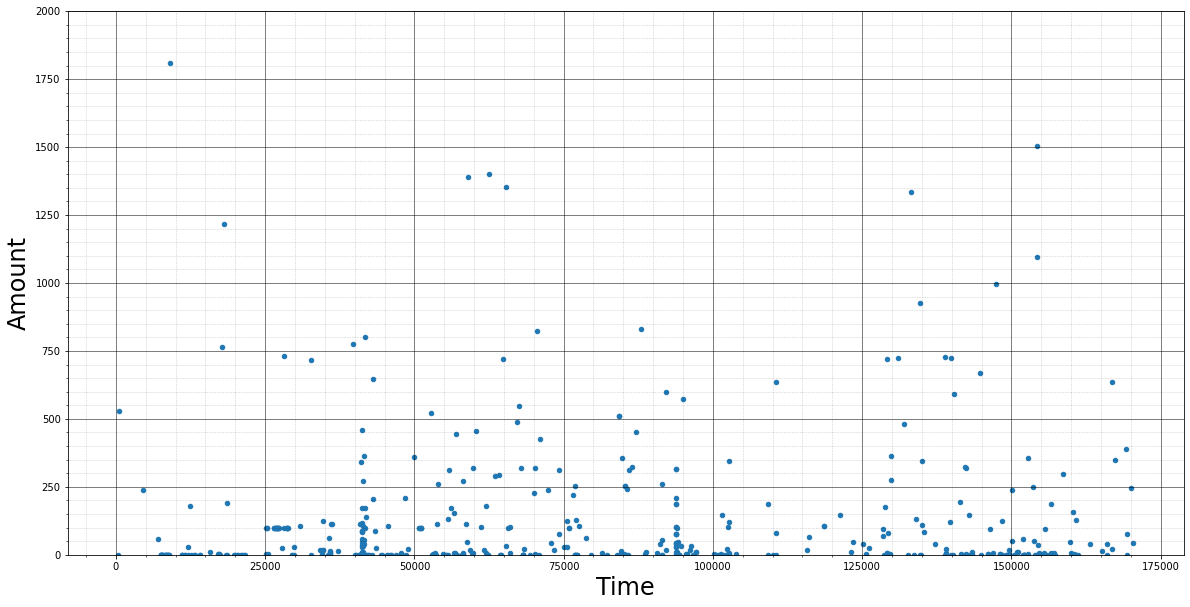

In [12]:
ax = df_credit.loc[df_credit.Class==1].plot(kind='scatter', x='Time', y='Amount', figsize=(20,10), ylim=(0,2000))

ax.set_xlabel('Time',fontdict={'fontsize':24})
ax.set_ylabel('Amount',fontdict={'fontsize':24})
ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 

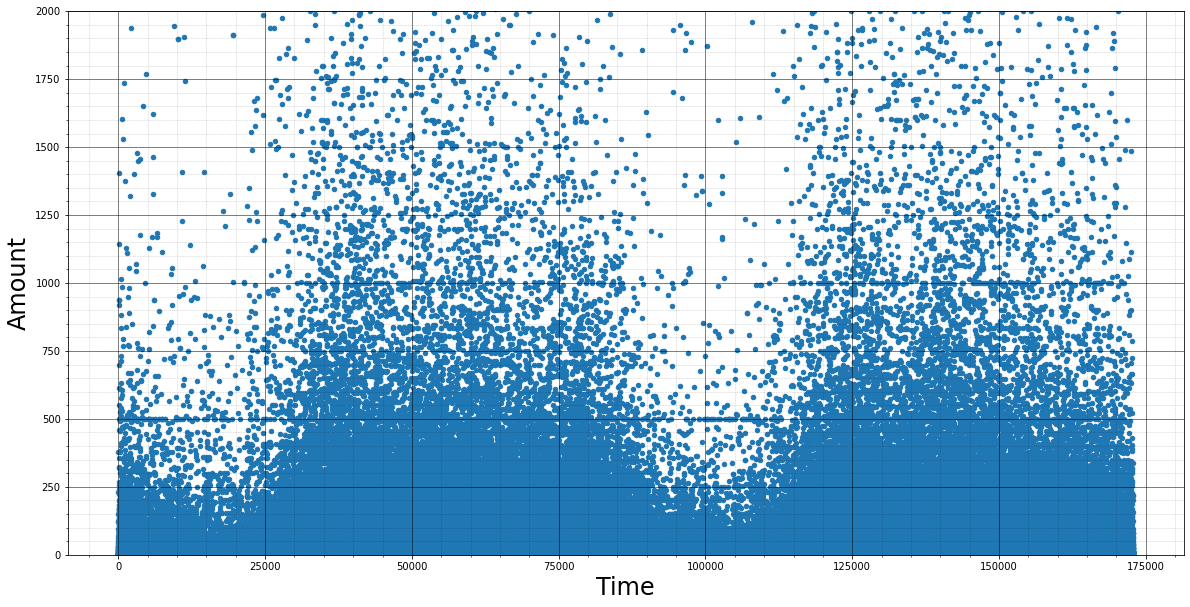

In [13]:
ax = df_credit.loc[df_credit.Class==0].plot(kind='scatter', x='Time', y='Amount', figsize=(20,10), ylim=(0,2000))

ax.set_xlabel('Time',fontdict={'fontsize':24})
ax.set_ylabel('Amount',fontdict={'fontsize':24})
ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 

In [14]:
df_credit.corr().style.set_table_styles(stylepattern).background_gradient(cmap='Purples').applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Time,1.0000,0.1174,-0.0106,-0.4196,-0.1053,0.1731,-0.0630,0.0847,-0.0369,-0.0087,0.0306,-0.2477,0.1243,-0.0659,-0.0988,-0.1835,0.0119,-0.0733,0.0904,0.0290,-0.0509,0.0447,0.1441,0.0511,-0.0162,-0.2331,-0.0414,-0.0051,-0.0094,-0.0106,-0.0123
V1,0.1174,1.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.2277,-0.1013
V2,-0.0106,0.0000,1.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.5314,0.0913
V3,-0.4196,-0.0000,0.0000,1.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.2109,-0.1930
V4,-0.1053,0.0000,-0.0000,-0.0000,1.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0987,0.1334
V5,0.1731,0.0000,-0.0000,-0.0000,-0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.3864,-0.0950
V6,-0.0630,0.0000,0.0000,0.0000,-0.0000,0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.2160,-0.0436
V7,0.0847,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,1.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.3973,-0.1873
V8,-0.0369,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,1.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.1031,0.0199




### Soma, média, desvio padrão e variancia dos valores monetário das operações legítimas (0) e fraudulentas (1).

In [15]:
pd.pivot_table(df_credit,index='Class',values='Amount',aggfunc=['mean','sum','std','var'],margins=True,margins_name='Total')\
            .style.set_table_styles(stylepattern)

,mean,sum,std,var
Features,Amount,Amount,Amount,Amount
Class,,,,
0,88.2910,25102462.0400,250.1051,62552.5572
1,122.2113,60127.9700,256.6833,65886.3105
Total,88.3496,25162590.0100,250.1201,62560.0690


### APRENDIZADO DE MÁQUINA E TUNNING

In [16]:
sc = StandardScaler()
df_credit.Amount = sc.fit_transform(df_credit.Amount.values.reshape(-1, 1))
df_credit.drop(columns='Time',inplace=True)


In [17]:
df_credit.head(20).style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,0.2450,0
1,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,-0.3425,0
2,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,1.1607,0
3,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,0.1405,0
4,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,-0.0734,0
5,-0.4260,0.9605,1.1411,-0.1683,0.4210,-0.0297,0.4762,0.2603,-0.5687,-0.3714,1.3413,0.3599,-0.3581,-0.1371,0.5176,0.4017,-0.0581,0.0687,-0.0332,0.0850,-0.2083,-0.5598,-0.0264,-0.3714,-0.2328,0.1059,0.2538,0.0811,-0.3386,0
6,1.2297,0.1410,0.0454,1.2026,0.1919,0.2727,-0.0052,0.0812,0.4650,-0.0993,-1.4169,-0.1538,-0.7511,0.1674,0.0501,-0.4436,0.0028,-0.6120,-0.0456,-0.2196,-0.1677,-0.2707,-0.1541,-0.7801,0.7501,-0.2572,0.0345,0.0052,-0.3333,0
7,-0.6443,1.4180,1.0744,-0.4922,0.9489,0.4281,1.1206,-3.8079,0.6154,1.2494,-0.6195,0.2915,1.7580,-1.3239,0.6861,-0.0761,-1.2221,-0.3582,0.3245,-0.1567,1.9435,-1.0155,0.0575,-0.6497,-0.4153,-0.0516,-1.2069,-1.0853,-0.1901,0
8,-0.8943,0.2862,-0.1132,-0.2715,2.6696,3.7218,0.3701,0.8511,-0.3920,-0.4104,-0.7051,-0.1105,-0.2863,0.0744,-0.3288,-0.2101,-0.4998,0.1188,0.5703,0.0527,-0.0734,-0.2681,-0.2042,1.0116,0.3732,-0.3842,0.0117,0.1424,0.0194,0


In [18]:
treino, teste = train_test_split(df_credit, train_size=0.8)

x_treino = treino.iloc[:,0:29]
y_treino = treino.iloc[:,29]

x_teste = teste.iloc[:,0:29]
y_teste = teste.iloc[:,29]


In [19]:

'''class MyTuner(kt.tuners.BayesianOptimization):
  
    def run_trial(self, trial, *args, **kwargs):
         #You can add additional HyperParameters for preprocessing and custom training loops
         # via overriding `run_trial`
         kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 64, 256, step=16)
         #kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
         super(MyTuner, self).run_trial(trial, *args, **kwargs)


        
        

def tune_nn_model(hp):
    METRICS = [
      tf.keras.metrics.TruePositives(),
      tf.keras.metrics.FalsePositives(),
      tf.keras.metrics.TrueNegatives(),
      tf.keras.metrics.FalseNegatives(), 
      tf.keras.metrics.BinaryAccuracy(),
      tf.keras.metrics.Precision(),
      tf.keras.metrics.Recall(),
      tf.keras.metrics.AUC(curve='ROC'),
      #tf.keras.metrics.AUC(name='PRC', curve='PR') # precision-recall curve
      ]
    modelo = tf.keras.Sequential()
    
    #configurando o número de neurônios na primeira camada
    units1 = hp.Int(
          'units_' + str(1),
          min_value=2,
          max_value=64,
          step=1)
    modelo.add(tf.keras.layers.Dense(units=units1,
                                 activation="relu",
                                 input_shape=[x_treino.shape[1]]))

    #configurando o número de camadas ocultas e neurônios por camada 
    for i in range(hp.Int('num_layers', 1, 2)):
      units = hp.Int(
          'units_' + str(i),
          min_value=2,
          max_value=64,
          step=1
      )
      modelo.add(tf.keras.layers.Dense(units=units, activation='relu'))
      # configurando a taxa de dropout
      drop_rate = hp.Choice('drop_rate_' + str(i),
                            [
                              0.0, 0.1, 0.2, 0.3, 0.4,0.5
                            ])
     
      modelo.add(tf.keras.layers.Dropout(rate=drop_rate))

    #configurando o otimizador
    modelo.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # optimizers = hp.Choice('optimizers' + str(i), ['Adam','Nadam'])



    #compilando o modelo com a métrica acurácia
    modelo.compile(
        optimizer = tf.keras.optimizers.Nadam(),
        loss = tf.keras.losses.binary_crossentropy,
        metrics = tf.keras.metrics.AUC())
    return modelo #



b_tuner = MyTuner(
    tune_nn_model,
    objective = Objective(name="loss",direction="min"),
    max_trials=5,
    directory='teste_otimizao_batch',
    project_name='b_tune_nn3_AUC'
    )


# callback earlystopping com 10 épocas de paciência
earlyStopping=EarlyStopping(monitor="loss", patience=10, verbose=1, mode='auto')

#procura da melhor arquitetura
b_tuner.search(x=x_treino, y=y_treino, 
             epochs=1 ,callbacks=[earlyStopping]
             )

#seleciona-se as três melhores arquiteturas
best_model = b_tuner.get_best_models()[0]

#resumindo os resultados
prediction = best_model.predict(x_teste)
y_pred = prediction>0.5
score_BNN = accuracy_score(y_pred=y_pred, y_true=y_teste)
print('O score é:', score_BNN)

best_model.summary()

y_pred = best_model.predict(x_teste)



y_pred_boll = (y_pred > 0.5)
y_teste_boll = (y_teste> 0.5)

#y_pred_order = np.sort(y_pred,axis=0)



tn, fp, fn, tp = confusion_matrix(y_teste,y_pred_boll).ravel()

cm = confusion_matrix(y_teste,y_pred_boll)

print(cm)



print(classification_report(y_teste,y_pred_boll))
'''

'class MyTuner(kt.tuners.BayesianOptimization):\n  \n    def run_trial(self, trial, *args, **kwargs):\n         #You can add additional HyperParameters for preprocessing and custom training loops\n         # via overriding `run_trial`\n         kwargs[\'batch_size\'] = trial.hyperparameters.Int(\'batch_size\', 64, 256, step=16)\n         #kwargs[\'epochs\'] = trial.hyperparameters.Int(\'epochs\', 10, 30)\n         super(MyTuner, self).run_trial(trial, *args, **kwargs)\n\n\n        \n        \n\ndef tune_nn_model(hp):\n    METRICS = [\n      tf.keras.metrics.TruePositives(),\n      tf.keras.metrics.FalsePositives(),\n      tf.keras.metrics.TrueNegatives(),\n      tf.keras.metrics.FalseNegatives(), \n      tf.keras.metrics.BinaryAccuracy(),\n      tf.keras.metrics.Precision(),\n      tf.keras.metrics.Recall(),\n      tf.keras.metrics.AUC(curve=\'ROC\'),\n      #tf.keras.metrics.AUC(name=\'PRC\', curve=\'PR\') # precision-recall curve\n      ]\n    modelo = tf.keras.Sequential()\n    \n  